In [71]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [72]:
coins = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'BNB-USD']

In [73]:
coin_data = yf.download(coins,
                   start='2024-07-01',
                   end='2025-07-01',
                   interval='1h',
                   group_by='coins',
                   threads=True)

[*********************100%***********************]  5 of 5 completed


In [74]:
results = []

for coin in coins:
    coin_close_data = coin_data[coin]['Close'].dropna()
    adf_result = adfuller(coin_close_data)
    p_value = adf_result[1]
    results.append({'Coin': coin, 'p-value': p_value})

    print(f'***** {coin} Results:')
    print(f'p-value: {p_value}')
    print()

***** BTC-USD Results:
p-value: 0.8011319198552553

***** ETH-USD Results:
p-value: 0.45417398749053806

***** USDT-USD Results:
p-value: 1.206019767046143e-06

***** XRP-USD Results:
p-value: 0.7204192000601403

***** BNB-USD Results:
p-value: 0.17065511396443683



In [75]:
results_df = pd.DataFrame(results)
sorted_results_df = results_df.sort_values(by='p-value')
print("Sorted by P-Value: \n\n", sorted_results_df)

Sorted by P-Value: 

        Coin   p-value
2  USDT-USD  0.000001
4   BNB-USD  0.170655
1   ETH-USD  0.454174
3   XRP-USD  0.720419
0   BTC-USD  0.801132


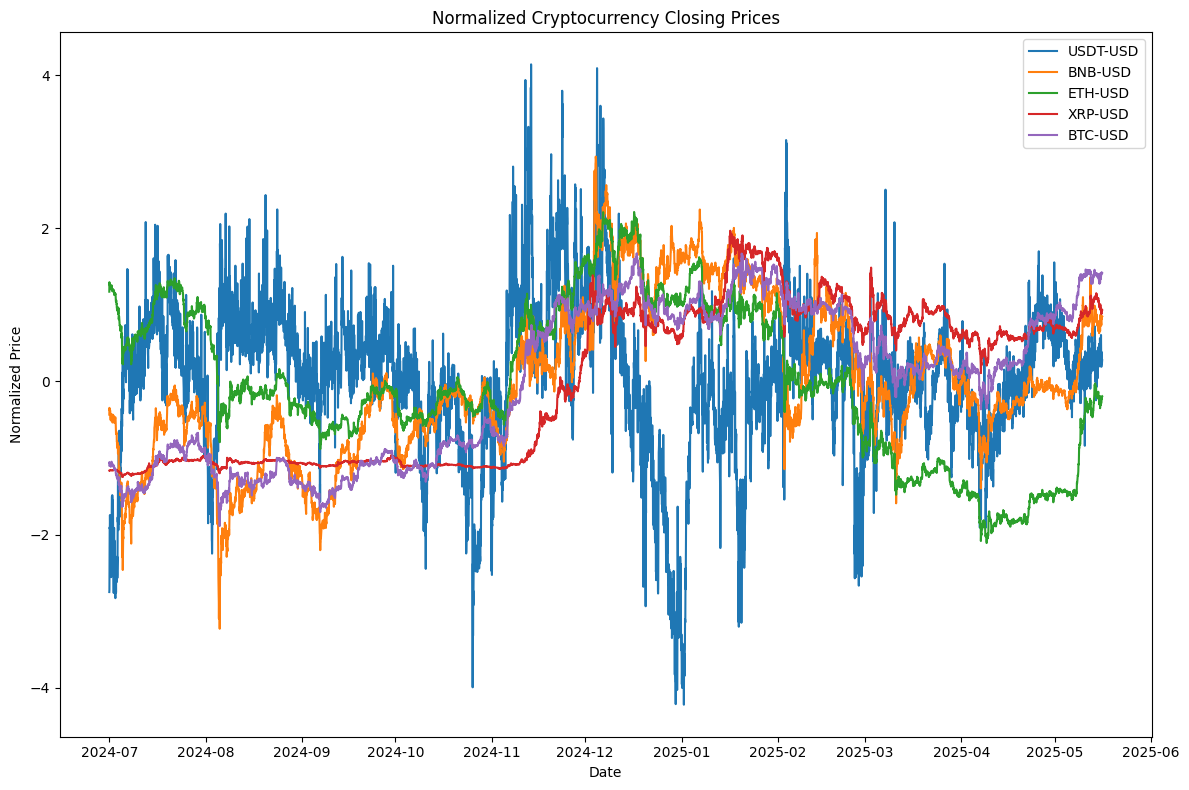

In [76]:
plt.figure(figsize=(12, 8))
for i, row in sorted_results_df.iterrows():
    ticker = row['Coin']
    series = coin_data[ticker]['Close'].dropna()
    normalized_series = (series - series.mean()) / series.std()
    plt.plot(normalized_series, label=ticker)
plt.title('Normalized Cryptocurrency Closing Prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
btc_close_data = coin_data['BTC-USD']['Close'].dropna()
btc_diff = btc_close_data.diff().dropna()

BTC p-value: 0.0


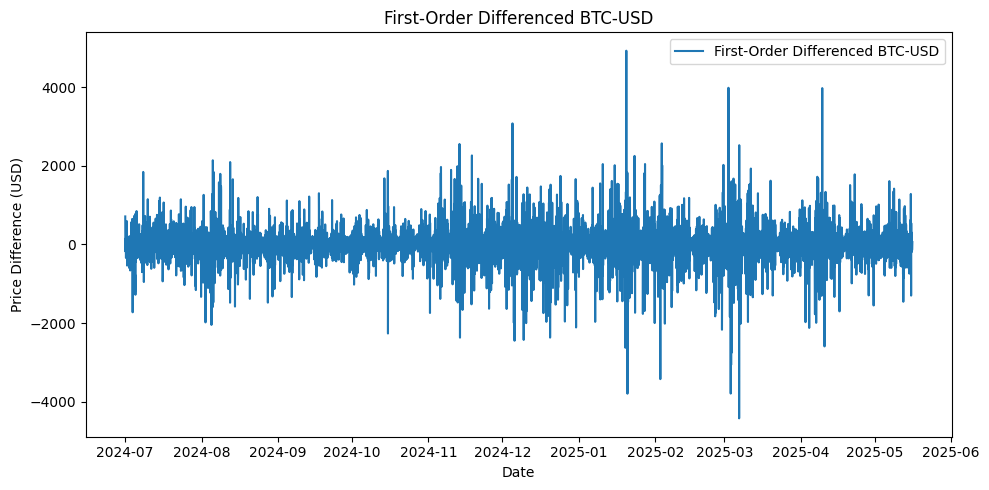

In [79]:
btc_adf_result = adfuller(btc_diff)
print(f'BTC p-value: {btc_adf_result[1]}')

plt.figure(figsize=(10, 5))
plt.plot(btc_diff, label='First-Order Differenced BTC-USD')
plt.title('First-Order Differenced BTC-USD')
plt.xlabel('Date')
plt.ylabel('Price Difference (USD)')
plt.legend()
plt.tight_layout()
plt.show()